# Signal denoising using RNNs in PyTorch

In this post, I'll use PyTorch to create a simple Recurrent Neural Network (RNN) for denoising a signal. I started learning RNNs using PyTorch. However, I felt that many of the examples were fairly complex. So, here's an attempt to create a simple example.

### Problem description

Given a noisy sine wave as an input, we want to estimate the denoised signal. This is shown in the figure below.

![](denoising.png)

### Customary imports

In [1]:
import sys
sys.path.append("../code/")
from common import APPLIANCES_ORDER


import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
tensor = np.load('../1H-input.npy')

### Creating noisy and denoised signals

Let's now write functions to cerate a sine wave, add some noise on top of it. This way we're able to create a noisy verison of the sine wave.

In [2]:
def create_subset_dataset(tensor, start=160, num_days=112):
    t_subset = tensor[:, :, start:start+num_days, :]
    all_indices = np.array(list(range(320)))
    for i in range(1, 7):
        valid_homes = pd.DataFrame(t_subset[:, i, :].reshape(320, num_days*24)).dropna().index
        all_indices = np.intersect1d(all_indices, valid_homes)
    print(len(all_indices))
    t_subset = t_subset[all_indices, :, :, :].reshape(len(all_indices), 7, num_days*24)
    
    # Create artificial aggregate
    t_subset[:, 0, :] = 0.0
    for i in range(1, 7):
        t_subset[:, 0, :] = t_subset[:, 0, :] + t_subset[:, i, :]
    # t_subset is of shape (#home, appliance, days*hours)
    return t_subset, all_indices

Let's now invoke the functions we defined to generate the figure we saw in the problem description.

In [3]:
t_all, valid_homes = create_subset_dataset(tensor)
t_all.shape

52


(52, 7, 2688)

### Creating dataset

Now, let's write a simple function to generate a dataset of such noisy and denoised samples.

In [4]:
num_days = 112
train_agg = t_all[:30, 0, :].reshape(30*num_days, 24)

train_hvac = t_all[:30, 1, :].reshape(30*num_days, 24)
train_fridge = t_all[:30, 2, :].reshape(30*num_days, 24)
train_mw = t_all[:30, 3, :].reshape(30*num_days, 24)
train_dw = t_all[:30, 4, :].reshape(30*num_days, 24)
train_wm = t_all[:30, 5, :].reshape(30*num_days, 24)
train_oven = t_all[:30, 6, :].reshape(30*num_days, 24)








train_agg_new = train_hvac + train_fridge





test_hvac = t_all[30:52, 1, :].reshape(22*num_days, 24)
test_fridge = t_all[30:52, 2, :].reshape(22*num_days, 24)
test_mw = t_all[30:52, 3, :].reshape(22*num_days, 24)
test_dw = t_all[30:52, 4, :].reshape(22*num_days, 24)
test_wm = t_all[30:52, 5, :].reshape(22*num_days, 24)
test_oven = t_all[30:52, 6, :].reshape(22*num_days, 24)
test_appliance = t_all[30:52, 1:, :].reshape(22*num_days, 6*24)









test_agg = t_all[30:, 0, :].reshape(22*num_days, 24)
test_agg_new = test_hvac + test_fridge




Now, creating the dataset, and dividing it into train and test set.

In [8]:
train_agg.reshape(-1,24, 1).shape

(3360, 24, 1)

In [9]:
import torch
import torch.nn as nn
from torch.autograd import Variable

### Creating RNN

We have 1d sine waves, which we want to denoise. Thus, we have input dimension of 1. Let's create a simple 1-layer RNN with 25 hidden units. 

In [219]:
class AppliancesRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_appliance):
        super(AppliancesRNN, self).__init__()
        self.num_appliance = num_appliance
        self.preds = {}
        for appliance in range(self.num_appliance):
            setattr(self, "Appliance_"+str(appliance),  CustomRNN(input_size, hidden_size, output_size)) 
    
    def forward(self, x):
        agg = x
        
        for appliance in range(self.num_appliance):
            self.preds[appliance] = getattr(self, "Appliance_"+str(appliance))(agg)
            agg = agg - self.preds[appliance]
        
        return torch.cat([self.preds[a] for a in range(self.num_appliance)])
    

In [220]:
input_dim = 1
hidden_size = 200
num_layers = 1
class CustomRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CustomRNN, self).__init__()
        self.rnn = nn.GRU(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, output_size, )
    def forward(self, x):
        pred, hidden = self.rnn(x, None)
        pred = self.linear(pred).view(pred.data.shape[0], -1, 1)
        pred = torch.clamp(pred, min=0.)
        pred = torch.min(pred, x)
        
        return pred


### Training

In [221]:
a= AppliancesRNN(input_dim, hidden_size, 1, 3)
print(a)

AppliancesRNN (
  (Appliance_0): CustomRNN (
    (rnn): GRU(1, 200, batch_first=True)
    (linear): Linear (200 -> 1)
  )
  (Appliance_1): CustomRNN (
    (rnn): GRU(1, 200, batch_first=True)
    (linear): Linear (200 -> 1)
  )
  (Appliance_2): CustomRNN (
    (rnn): GRU(1, 200, batch_first=True)
    (linear): Linear (200 -> 1)
  )
)


In [222]:
0 514.653564453125
5 317.0882568359375
10 200.26992797851562
15 139.7920379638672
20 109.28858947753906
25 94.39302825927734
30 86.12940216064453
35 81.29493713378906
40 79.03305053710938
45 77.94844818115234

SyntaxError: invalid syntax (<ipython-input-222-77c64d6e077a>, line 1)

In [223]:
a= AppliancesRNN(input_dim, hidden_size, 1, 3)
print(a)
# Storing predictions per iterations to visualise later
predictions = []

optimizer = torch.optim.Adam(a.parameters(), lr=4)
loss_func = nn.L1Loss()

for t in range(200):
    
    inp = Variable(torch.Tensor(train_agg.reshape((train_agg.shape[0], -1, 1))), requires_grad=True)
    out_hvac = Variable(torch.Tensor(train_hvac.reshape((train_hvac.shape[0], -1, 1))) )
    out_fridge = Variable(torch.Tensor(train_fridge.reshape((train_fridge.shape[0], -1, 1))) )
    out_oven = Variable(torch.Tensor(train_oven.reshape((train_fridge.shape[0], -1, 1))) )


    out = torch.cat([out_hvac , out_fridge, out_oven,])
    
    pred = a(inp)
   
    optimizer.zero_grad()
    predictions.append(pred.data.numpy())
    loss = loss_func(pred, out)
    if t%5==0:
        print(t, loss.data[0])
    loss.backward()
    optimizer.step()

AppliancesRNN (
  (Appliance_0): CustomRNN (
    (rnn): GRU(1, 200, batch_first=True)
    (linear): Linear (200 -> 1)
  )
  (Appliance_1): CustomRNN (
    (rnn): GRU(1, 200, batch_first=True)
    (linear): Linear (200 -> 1)
  )
  (Appliance_2): CustomRNN (
    (rnn): GRU(1, 200, batch_first=True)
    (linear): Linear (200 -> 1)
  )
)
0 347.9401550292969
5 116.5162353515625
10 78.14385223388672
15 78.3295669555664
20 78.70917510986328
25 78.79183197021484
30 78.81785583496094
35 78.82999420166016


KeyboardInterrupt: 

In [ ]:
len(list(a.parameters()))

In [ ]:
r= CustomRNN(input_dim, hidden_size, 1)
print(r)
# Storing predictions per iterations to visualise later
predictions = []

optimizer = torch.optim.Adam(r.parameters(), lr=2)
loss_func = nn.L1Loss()

for t in range(200):
    
    inp = Variable(torch.Tensor(train_agg.reshape((train_agg.shape[0], -1, 1))), requires_grad=True)
    out = Variable(torch.Tensor(train_fridge.reshape((train_fridge.shape[0], -1, 1))) )
    pred = r(inp)
   
    optimizer.zero_grad()
    predictions.append(pred.data.numpy())
    loss = loss_func(pred, out)
    if t%5==0:
        print(t, loss.data[0])
    loss.backward()
    optimizer.step()

In [211]:
p = a(Variable(torch.Tensor(test_agg.reshape((test_agg.shape[0], -1, 1))), requires_grad=True))

In [212]:
pred_oven, pred_fridge , pred_hvac  = torch.split(p, test_agg.shape[0])


In [213]:
pred_hvac_np = pred_hvac.data.numpy().reshape(-1, 24)
pred_fridge_np = pred_fridge.data.numpy().reshape(-1, 24)
pred_oven_np = pred_oven.data.numpy().reshape(-1, 24)





from sklearn.metrics import mean_absolute_error
mean_absolute_error(pred_hvac_np, test_hvac), mean_absolute_error(pred_fridge_np, test_fridge), mean_absolute_error(pred_oven_np, test_oven), 

(130.43438706383208, 87.032837842362667, 18.429772049169337)

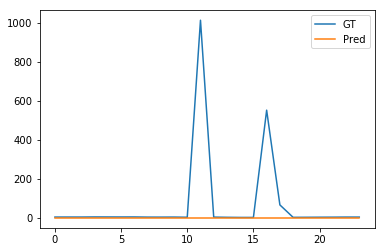

In [218]:
plt.plot(test_oven[0, :], label='GT')
plt.plot(pred_oven_np[0, :], label='Pred')
plt.legend()

In [96]:
loss_func(pred_hvac, Variable(torch.Tensor(test_fridge.reshape((test_fridge.shape[0], -1, 1)))) )

Variable containing:
 30.0342
[torch.FloatTensor of size 1]

Great. As expected, the loss reduces over time.

In [32]:
r()

torch.Size([1, 3360, 25])

In [59]:
# Test loss
print(loss_func(pred_t, Variable(torch.Tensor(test_out.reshape((test_inp.shape[0], -1, 1))))).data[0])

NameError: name 'pred_t' is not defined

### Visualising sample denoising

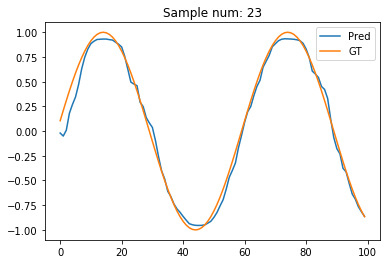

In [11]:
sample_num = 23
plt.plot(pred_t[sample_num].data.numpy(), label='Pred')
plt.plot(test_out[sample_num], label='GT')
plt.legend()
plt.title("Sample num: {}".format(sample_num))

Seems pretty neat to me!

### Visualising estimations as model improves

Let's now write a simple function to visualise the estimations as a function of iterations. We'd expect the estimations to improve over time.

In [14]:
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots(figsize=(4, 3))
fig.set_tight_layout(True)

# Query the figure's on-screen size and DPI. Note that when saving the figure to
# a file, we need to provide a DPI for that separately.
print('fig size: {0} DPI, size in inches {1}'.format(
    fig.get_dpi(), fig.get_size_inches()))

def update(i):
    label = 'Iteration {0}'.format(i)
    ax.cla()
    ax.plot(np.array(predictions)[i, 0, :, 0].T, label='Pred')
    ax.plot(train_out[0, :], label='GT')
    ax.legend()
    ax.set_title(label)
 

anim = FuncAnimation(fig, update, frames=range(0, 200), interval=10)
anim.save('learning.mp4',fps=20)
plt.close()

fig size: 72.0 DPI, size in inches [ 4.  3.]


In [15]:
from IPython.display import Video
Video("learning.mp4")

This looks great! We can see how our model learns to learn reasonably good denoised signals over time. It doesn't start great though. Would a better initialisation help? I certainly feel that for this particular problem it would, as predicting the output the same as input is a good starting point!

I must also thank Simon Wang and his helpful inputs on the [PyTorch discussion forum](https://discuss.pytorch.org/t/problem-with-vanilla-rnn/12235/12).